In [1]:
import os
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF

import PIL
import cv2

import timm

import albumentations as A
from albumentations import (
    Compose, OneOf, Normalize, CenterCrop, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, RandomRotate90, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, HueSaturationValue, CoarseDropout
    )
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")

import logging
import time
from contextlib import contextmanager

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
DATA_DIR = '../input/plant-pathology-2021-fgvc8/'
TEST_DIR = DATA_DIR + 'test_images/'
TRAIN_DIR = DATA_DIR + 'train_images/'
TRAIN_CSV_DIR = DATA_DIR + 'train.csv'
TEST_CSV_DIR = DATA_DIR + 'sample_submission.csv'
train_df = pd.read_csv(TRAIN_CSV_DIR)
test_df = pd.read_csv(TEST_CSV_DIR)

In [3]:
TARGET = train_df['labels'].unique()
TARGET

array(['healthy', 'scab frog_eye_leaf_spot complex', 'scab', 'complex',
       'rust', 'frog_eye_leaf_spot', 'powdery_mildew',
       'scab frog_eye_leaf_spot', 'frog_eye_leaf_spot complex',
       'rust frog_eye_leaf_spot', 'powdery_mildew complex',
       'rust complex'], dtype=object)

In [4]:
onehot_df = pd.get_dummies(train_df, columns=['labels'])
col = onehot_df.drop('image', axis=1) #変換したラベルを取得する
TARGET_COLUMNS = col.columns.values
TARGET_COLUMNS

array(['labels_complex', 'labels_frog_eye_leaf_spot',
       'labels_frog_eye_leaf_spot complex', 'labels_healthy',
       'labels_powdery_mildew', 'labels_powdery_mildew complex',
       'labels_rust', 'labels_rust complex',
       'labels_rust frog_eye_leaf_spot', 'labels_scab',
       'labels_scab frog_eye_leaf_spot',
       'labels_scab frog_eye_leaf_spot complex'], dtype=object)

In [5]:
DEBUG = True
if DEBUG:
    onehot_df = onehot_df.sample(frac = 0.15).reset_index(drop = True)
    print(onehot_df.shape)

(2795, 13)


In [6]:
CFG = {
    'seed': 719,
    'model_arch': 'resnet50',
    'img_size': 320,
    'epochs': 3,
    'num_workers': 4,
}

@contextmanager
def timer(name, logger=None, level=logging.DEBUG):
    print_ = print if logger is None else lambda msg: logger.log(level, msg)
    t0 = time.time()
    print_(f'[{name}] start')
    yield
    print_(f'[{name}] done in {time.time() - t0:.0f} s')

In [7]:
from sklearn.model_selection import train_test_split
train, valid =  train_test_split(onehot_df, test_size = 0.1)
print(train.shape, valid.shape)

(2515, 13) (280, 13)


In [8]:
#pytorchのDatasetクラスを継承したクラスを作成する
class TrainDataset(Dataset):
    def __init__(self, onehot_df, transform = None):
        self.onehot_df = onehot_df
        self.image_names = onehot_df["image"].values
        self.labels = onehot_df[TARGET_COLUMNS].values
        self.transform = transform
        
    def __len__(self):
        return len(self.onehot_df)
    
#indexに対応する画像とラベルを返す関数
    def __getitem__(self, idx):
        image_name = self.image_names[idx] #indexに対応するimageの値
        image_path = TRAIN_DIR + image_name #indexに対応するデータのパス
        image = cv2.imread(image_path) #画像読み込み
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #BGR→RGB
        #label = self.labels[idx] #indexに対応するラベル
        label = torch.tensor(self.labels[idx]).float()
        if self.transform: #前処理ある場合
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

In [9]:
class TestDataset(Dataset):
    def __init__(self, onehot_df, transform = None):
        self.onehot_df = onehot_df
        self.image_names = onehot_df["image"].values
        self.transform = transform
        
    def __len__(self):
        return len(self.onehot_df)
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = TEST_DIR + image_name
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        #image = Resize(IMAGE_SIZE, IMAGE_SIZE)(image = image)["image"]
        #image = ToTensorV2()(image = image)["image"]
        return image

In [10]:
def get_transforms(*,data):
    
    if data == 'train':
        return Compose([
            Resize(CFG['img_size'], CFG['img_size']),
            RandomResizedCrop(CFG['img_size'], CFG['img_size'], scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            RandomBrightnessContrast(p=0.5),
            Normalize(),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return Compose([
            Resize(CFG['img_size'], CFG['img_size']),
            #RandomResizedCrop(600, 600, scale=(0.85, 1.0)),
            #HorizontalFlip(p=0.5),
            Normalize(),
            ToTensorV2(),
        ])

In [11]:
#train_dataset = TrainDataset(onehot_df, transform = None)
train_dataset = TrainDataset(onehot_df, transform = get_transforms(data = 'train'))
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers = 2, drop_last = True)
train_dataset[0]

(tensor([[[ 2.0434,  2.0263,  2.0263,  ..., -0.1828, -0.2513, -0.3198],
          [ 2.0777,  2.0777,  2.0263,  ..., -0.1828, -0.2513, -0.3369],
          [ 2.0777,  2.1119,  2.0777,  ..., -0.1828, -0.2513, -0.3369],
          ...,
          [ 0.2111,  0.2111,  0.2282,  ..., -1.3815, -1.3473, -1.3130],
          [ 0.2111,  0.2111,  0.2111,  ..., -1.3815, -1.3987, -1.3473],
          [ 0.1939,  0.1768,  0.1597,  ..., -1.3987, -1.3815, -1.3644]],
 
         [[ 2.4286,  2.4286,  2.4286,  ...,  0.3978,  0.3102,  0.2227],
          [ 2.4286,  2.4286,  2.4286,  ...,  0.3627,  0.3102,  0.2052],
          [ 2.4286,  2.4286,  2.4286,  ...,  0.3277,  0.2927,  0.2227],
          ...,
          [ 0.8880,  0.8704,  0.8529,  ..., -1.0378, -0.9853, -0.8978],
          [ 0.8354,  0.8179,  0.8004,  ..., -1.0553, -1.0028, -0.8978],
          [ 0.8004,  0.7479,  0.7129,  ..., -1.0903, -1.0203, -0.8978]],
 
         [[ 2.0823,  2.0474,  1.9777,  ..., -0.5147, -0.6018, -0.6890],
          [ 2.0997,  2.0997,

In [12]:
valid_dataset = TrainDataset(onehot_df, transform = get_transforms(data = 'valid'))
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = False)
valid_dataset[0]

(tensor([[[-0.4054, -0.4226, -0.3369,  ...,  1.4440,  1.4269,  1.4098],
          [-0.4226, -0.4911, -0.4568,  ...,  1.3927,  1.3755,  1.3755],
          [-0.5082, -0.4911, -0.4911,  ...,  1.3927,  1.2899,  1.3584],
          ...,
          [ 2.1119,  2.1119,  2.1119,  ..., -1.2445, -1.2617, -1.2959],
          [ 2.0605,  2.0777,  2.0777,  ..., -1.2445, -1.2445, -1.3130],
          [ 2.0777,  2.0777,  2.0605,  ..., -1.2445, -1.2617, -1.2788]],
 
         [[ 0.0476,  0.0476,  0.1176,  ...,  0.6078,  0.5903,  0.5728],
          [ 0.0301, -0.0399, -0.0049,  ...,  0.5553,  0.5378,  0.5378],
          [-0.0574, -0.0749, -0.0749,  ...,  0.6429,  0.5378,  0.5553],
          ...,
          [ 2.1660,  2.1835,  2.2010,  ..., -0.8452, -0.8627, -0.8452],
          [ 2.1835,  2.2010,  2.2010,  ..., -0.8452, -0.8452, -0.8803],
          [ 2.2010,  2.2010,  2.1835,  ..., -0.8452, -0.8627, -0.8627]],
 
         [[-0.5147, -0.5321, -0.4624,  ...,  0.5311,  0.5311,  0.4962],
          [-0.5321, -0.6018,

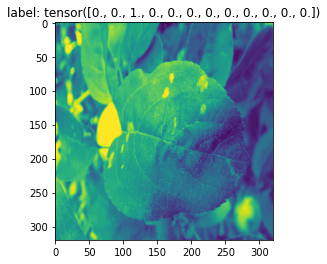

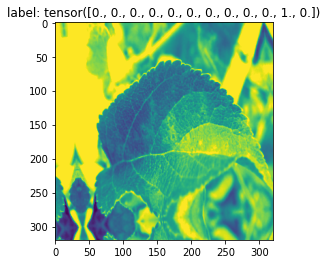

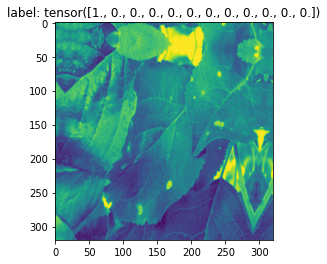

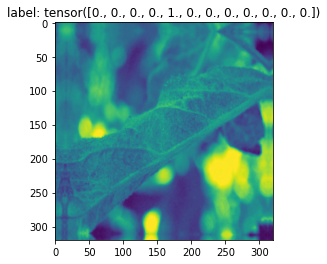

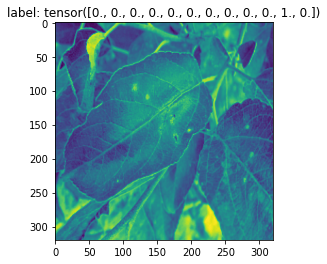

In [13]:
for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [14]:
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.myresnet = timm.create_model(model_name = 'resnet50',pretrained = False)
        in_features = self.myresnet.get_classifier().in_features
        self.myresnet.fc = nn.Linear(in_features, len(TARGET_COLUMNS))
        
    def forward(self, x):
        x = self.myresnet(x)
        return x
    
model = MyResNet()
model = model.to(DEVICE)
print(DEVICE)

cuda


In [15]:
with timer('training'):
    
    model = MyResNet().to(DEVICE)

    #criterion:LogisticLoss
    criterion = nn.BCEWithLogitsLoss()
    #optimizer:Adam
    optimizer = torch.optim.Adam(model.parameters())

    best_loss = np.inf
    for epoch in range(5):
            model.train()
            for X, y in train_loader:
                optimizer.zero_grad()
                X = X.float().to(DEVICE)
                y = y.float().to(DEVICE)
                pred = model(X)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
            model.eval()
            valid_loss = 0
            with torch.no_grad():
                for X, y in valid_loader:
                    X = X.float().to(DEVICE)
                    y = y.float().to(DEVICE)
                    pred = model(X)
                    loss = criterion(pred, y)
                    valid_loss += loss.item()
            valid_loss /= len(valid_loader)
            print(f"EPOCH:{epoch}, Loss:{valid_loss}")
            if valid_loss < best_loss:
                best_loss = valid_loss
                torch.save(model.state_dict(), "MyResNet.pth")
                print("saved")


[training] start
EPOCH:0, Loss:0.21926398168910632
saved
EPOCH:1, Loss:0.21871394833380525
saved
EPOCH:2, Loss:0.1934488324279135
saved
EPOCH:3, Loss:0.1690644318745895
saved
EPOCH:4, Loss:0.15744254992089488
saved
[training] done in 3405 s


In [16]:
model = MyResNet().to(DEVICE)
model.load_state_dict(torch.load("./MyResNet.pth"),strict=False)
#/root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth

<All keys matched successfully>

In [17]:
test_dataset = TestDataset(test_df, transform = get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [18]:
submit_preds = []

model.eval()
with torch.no_grad():
    for X in test_loader:
        X = X.float().to(DEVICE)
        submit_preds.append(model(X).sigmoid().to("cpu"))
    submit_preds = np.concatenate([p.numpy() for p in submit_preds], axis = 0)

In [19]:
submit = pd.DataFrame(submit_preds, index = test_df['image'], columns = TARGET)
submit.head()

,healthy,scab frog_eye_leaf_spot complex,scab,complex,rust,frog_eye_leaf_spot,powdery_mildew,scab frog_eye_leaf_spot,frog_eye_leaf_spot complex,rust frog_eye_leaf_spot,powdery_mildew complex,rust complex
image,,,,,,,,,,,,
85f8cb619c66b863.jpg,0.034198,0.018745,0.005106,0.301961,0.090277,0.007965,0.441322,0.007894,0.001881,0.154193,0.009304,0.000747
ad8770db05586b59.jpg,0.452661,0.361221,0.016959,0.000080,0.000114,0.002051,0.021517,0.097112,0.007576,0.002554,0.137512,0.114194
c7b03e718489f3ca.jpg,0.078801,0.418892,0.007383,0.002681,0.000264,0.002435,0.263973,0.061038,0.007757,0.012107,0.094152,0.013779


In [20]:
sub = submit.idxmax(axis = 1)
sub

image
85f8cb619c66b863.jpg                     powdery_mildew
ad8770db05586b59.jpg                            healthy
c7b03e718489f3ca.jpg    scab frog_eye_leaf_spot complex
dtype: object

In [21]:
submission = pd.DataFrame(sub,columns = ['labels'])
submission

,labels
image,
85f8cb619c66b863.jpg,powdery_mildew
ad8770db05586b59.jpg,healthy
c7b03e718489f3ca.jpg,scab frog_eye_leaf_spot complex


In [22]:
sub2 = submission.to_csv("submission.csv")
sub3 = pd.read_csv('./submission.csv')

In [23]:
print(test_df.shape, sub3.shape)

(3, 2) (3, 2)
